# King County Housing Data
## Zaria and Mahima

We started our project doing Exploratary Data Analysis on our entire dataset. We found that we couldn't get insights as clear we had hoped, so we decided to select a subset of the data. !!! 

We chose to subset the data on the basis of houses that would be most marketable to our target client.  We defined most-marketable as:
- Houses of grade 8 and above
- Houses with condition 4 and above
- Houses with >= 2 bedrooms


This gave us 792 properties (3% of the dataset) 

We identified outliers and dropped their corresponding rows, and dropped the entire 'Waterfront' column, which we felt had too few values to be able to explore. 

We then established three questions we would answer, and again performed EDA on our subset of data. Our three questions were: 
- Are houses typically surrounded by similar houses? 
- Can you predict sqft living from number of bathrooms? 
- Which areas are most desirable to our client?

We then created a linear model to estimate which factors influence the price the most. We selected variables that had a good correlation with price, but little correlation with each other as to avoid problems associated with multicollinearity. We chose to select SqFtLiving and Latitude, and found there was some correlation between the variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import sklearn
from sklearn import metrics
%matplotlib inline

In [2]:
#Importing our data
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
#Function to list column outliers
def remove_outlier(df_in, col_name):
   q1 = df_in[col_name].quantile(0.25)
   q3 = df_in[col_name].quantile(0.75)
   iqr = q3-q1 #Interquartile range
   fence_low  = q1 - 1.5*iqr
   fence_high = q3 + 1.5*iqr
   df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
   return df_out

In [4]:
#Dropping outliers from columns
price_drop = remove_outlier(df, 'price').index
df.drop(index= price_drop, inplace= True)

sqft_living_drop = remove_outlier(df, 'sqft_living').index
df.drop(index= sqft_living_drop, inplace= True)

sqft_living15_drop = remove_outlier(df, 'sqft_living15').index
df.drop(index= sqft_living15_drop, inplace= True)

sqft_lot_drop = remove_outlier(df, 'sqft_lot').index
df.drop(index= sqft_lot_drop, inplace= True)

sqft_lot15_drop = remove_outlier(df, 'sqft_lot15').index
df.drop(index= sqft_lot15_drop, inplace= True)

In [5]:
#Dropping NAN values and unecessary columns
df.dropna(subset=['view'], how='all', inplace=True)
df.drop(columns='waterfront', axis=1, inplace= True)

In [6]:
#Formatting 'Date' column as a datetime object
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Creating our data subset
data_df = df[(df['grade'] >=8) & (df['condition'] >=4) & (df['bedrooms'] >=2)]

In [8]:
display(data_df.info())
data_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657 entries, 24 to 21196
Data columns (total 20 columns):
id               1657 non-null int64
date             1657 non-null datetime64[ns]
price            1657 non-null float64
bedrooms         1657 non-null int64
bathrooms        1657 non-null float64
sqft_living      1657 non-null int64
sqft_lot         1657 non-null int64
floors           1657 non-null float64
view             1657 non-null float64
condition        1657 non-null int64
grade            1657 non-null int64
sqft_above       1657 non-null int64
sqft_basement    1657 non-null object
yr_built         1657 non-null int64
yr_renovated     1373 non-null float64
zipcode          1657 non-null int64
lat              1657 non-null float64
long             1657 non-null float64
sqft_living15    1657 non-null int64
sqft_lot15       1657 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(11), object(1)
memory usage: 271.9+ KB


None

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.657000e+03,1.657000e+03,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000,1373.000000,1657.000000,1657.000000,1657.000000,1657.000000,1657.000000
mean,4.848565e+09,6.314750e+05,3.643935,2.263126,2314.448401,8401.205794,1.395896,0.339167,4.222088,8.208811,1830.664454,1961.901629,43.507647,98070.775498,47.572357,-122.235829,2157.593241,8167.887145
std,2.855041e+09,2.160881e+05,0.813504,0.511877,543.656700,3226.314569,0.475735,0.877589,0.415776,0.464794,518.558165,23.605209,291.211495,57.765792,0.121150,0.109779,424.604390,2808.777920
min,3.120002e+07,1.499000e+05,2.000000,1.000000,920.000000,1339.000000,1.000000,0.000000,4.000000,8.000000,700.000000,1900.000000,0.000000,98001.000000,47.189600,-122.446000,950.000000,1062.000000
25%,2.469000e+09,4.640000e+05,3.000000,1.750000,1940.000000,6000.000000,1.000000,0.000000,4.000000,8.000000,1460.000000,1951.000000,0.000000,98023.000000,47.528400,-122.336000,1880.000000,5900.000000
50%,4.206901e+09,6.300000e+05,4.000000,2.250000,2250.000000,8400.000000,1.000000,0.000000,4.000000,8.000000,1730.000000,1967.000000,0.000000,98052.000000,47.588000,-122.222000,2130.000000,8348.000000
75%,7.575601e+09,7.900000e+05,4.000000,2.500000,2650.000000,10297.000000,2.000000,0.000000,4.000000,8.000000,2110.000000,1978.000000,0.000000,98117.000000,47.659500,-122.152000,2430.000000,10090.000000
max,9.839301e+09,1.120000e+06,7.000000,4.500000,3970.000000,17717.000000,3.000000,4.000000,5.000000,11.000000,3950.000000,2009.000000,2014.000000,98199.000000,47.777600,-121.786000,3410.000000,14636.000000


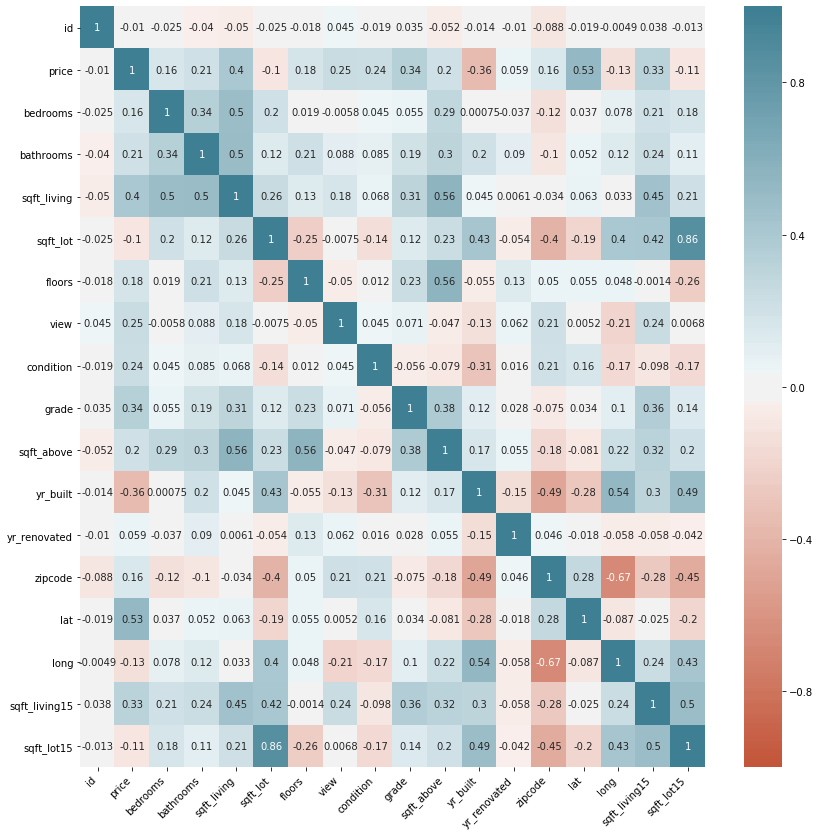

In [9]:
corr = data_df.corr()

plt.figure(figsize = (14,14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

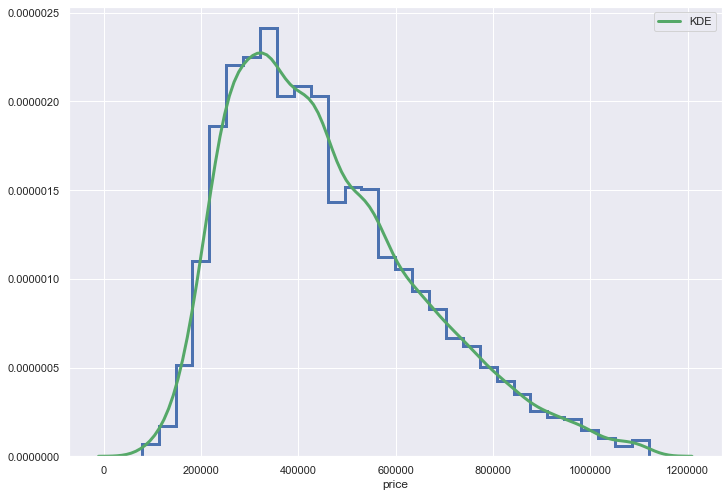

In [10]:
#density plot of price
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.distplot(df['price'], bins=30, kde_kws={"color": "g", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                  "alpha": 1, "color": "b"})
plt.show()

## Q1 - Are properties typically surrounded by similar properties?


To answer this question, we decided to compare SqFtLiving and SqFtLiving15, and SqFtLot and SqFtLot15. We noticed correlation on both graphs, but much higher with the size of the lot. This was reinforced when we built two linear models, showing each variable against their corresponding variable. We noticed whilst they were both correlated, they had a varying spread of their data points, and this was reflected in their R Sqaured values. 

This could suggest people typically buy houses surrounded by houses on a similar plot size, although the living size of each property varies. 

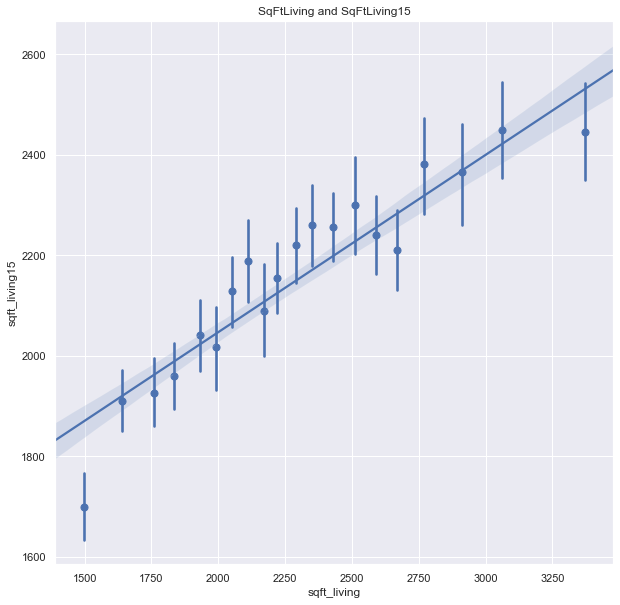

In [11]:
x = data_df['sqft_living']
y = data_df['sqft_living15']

plt.figure(figsize = (10,10))
sns.regplot(x , y, x_bins = 20, label='').set_title("SqFtLiving and SqFtLiving15")
plt.show()

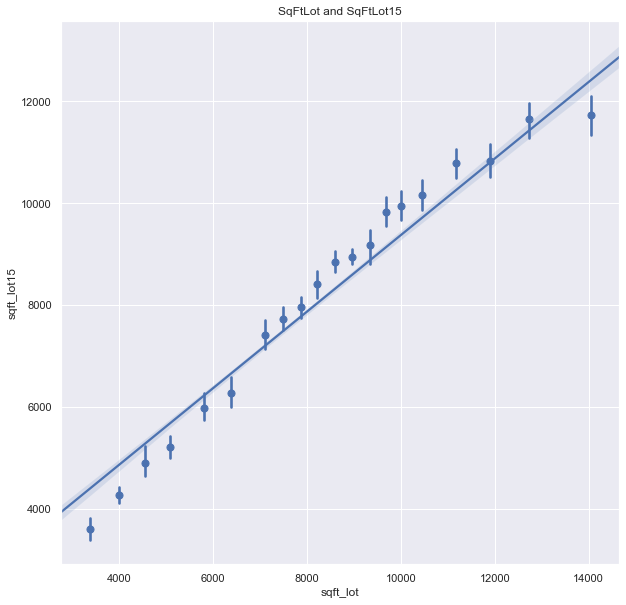

In [12]:
x = data_df['sqft_lot']
y = data_df['sqft_lot15']

plt.figure(figsize = (10,10))
sns.regplot(x , y, x_bins = 20).set_title("SqFtLot and SqFtLot15")
plt.show()

In [13]:
x = data_df['sqft_living']
y = data_df['sqft_living15']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sqft_living15   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     424.8
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           3.44e-84
Time:                        15:19:13   Log-Likelihood:                -12188.
No. Observations:                1657   AIC:                         2.438e+04
Df Residuals:                    1655   BIC:                         2.439e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1340.6884     40.715     32.928      0.000    1260.830    1420.547
sqft_living     0.3530      0.017     20.610      0.000       0.319       0.387
==============================================================================
Omnibus:                       10.430   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.326
Skew:                          -0.110   Prob(JB):                      0.00211
Kurtosis:                       3.361   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
x = data_df['sqft_lot']
y = data_df['sqft_lot15']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqft_lot15   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     4849.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:19:13   Log-Likelihood:                -14374.
No. Observations:                1657   AIC:                         2.875e+04
Df Residuals:                    1655   BIC:                         2.876e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1852.6248     97.142     19.071      0.000    1662.090    2043.159
sqft_lot       0.7517      0.011     69.637      0.000       0.731       0.773
==============================================================================
Omnibus:                      227.733   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1948.995
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                       8.269   Cond. No.                     2.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Q2 - Which zip-codes would be most desirable to our client?

We manipulated our data to group by postcode, longitude and latitude, and totalled how many desirable properties were in each area. We listed the top three values, which we would consider the most desirable area for our clients. We could then advise our clients on specific areas they may want to move to. 

In [15]:
post_df2 = data_df.groupby('zipcode')['zipcode'].count()
pd.DataFrame(post_df2)
post_df2.sort_values(ascending=False, inplace=True)
post_df2 = list(post_df2.head(3).keys())
post_df2

[98006, 98052, 98040]

In [16]:
long_df2 = data_df.groupby(['long','lat'])['long'].count()
pd.DataFrame(long_df2)
long_df2.sort_values(ascending=False, inplace=True)
long_df2 = list(long_df2.head(3).keys())
long_df2

[(-122.146, 47.6599), (-122.221, 47.5505), (-122.34899999999999, 47.6389)]

In [17]:
lat_df2 = data_df.groupby(['lat','long'])['lat'].count()
pd.DataFrame(lat_df2)
lat_df2.sort_values(ascending=False, inplace=True)
lat_df2 = list(lat_df2.head(3).keys())
lat_df2

[(47.6599, -122.146),
 (47.62600000000001, -122.11200000000001),
 (47.3326, -122.20100000000001)]

## Q3 - Can you predict the number of bathrooms from the living space? 

We built a simple model to estimate how many bathrooms could be expected in a property, when the SqFtLiving value was known. We intended for this model to be used once the ideal number of bathrooms in the new property has been decided, so the clients can have an estimate of how many SqFt they can expect from the property. Should this number be inadequate, they could see how much more or less living space they would have to compromise to reach a satisfactory number of bathrooms. 



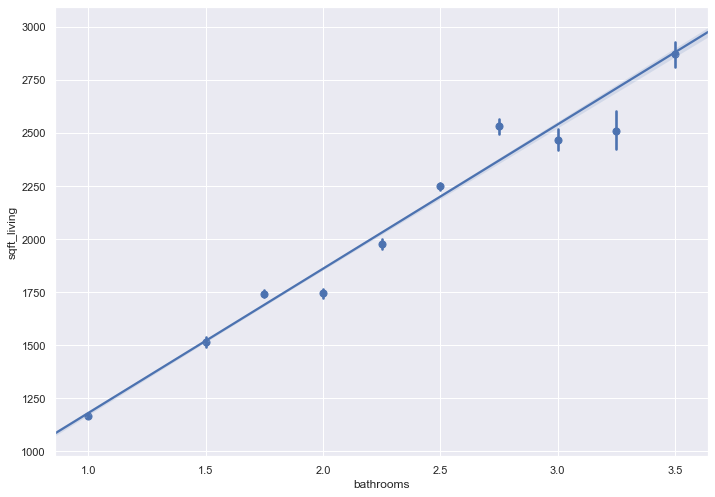

In [18]:
x = df['bathrooms']
y = df['sqft_living']
 
sns.regplot(x, y, x_bins = 50)
 
plt.show()

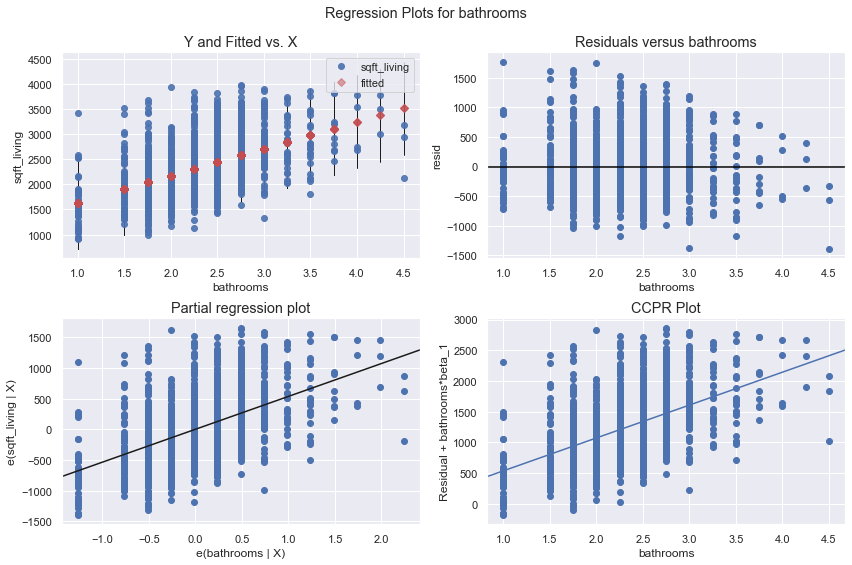

In [19]:
fig = plt.figure(figsize=(12, 8))
model = smf.ols('sqft_living ~ bathrooms', data=data_df).fit()
sm.graphics.plot_regress_exog(model, fig=fig, exog_idx='bathrooms')
plt.show()

In [20]:
x = data_df['bathrooms']
y = data_df['sqft_living']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     564.7
Date:                Wed, 23 Oct 2019   Prob (F-statistic):          1.22e-107
Time:                        15:19:29   Log-Likelihood:                -12544.
No. Observations:                1657   AIC:                         2.509e+04
Df Residuals:                    1655   BIC:                         2.510e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1102.0894     52.306     21.070      0.000     999.497    1204.681
bathrooms    535.7010     22.543     23.764      0.000     491.485     579.917
==============================================================================
Omnibus:                       81.564   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.004
Skew:                           0.553   Prob(JB):                     6.37e-21
Kurtosis:                       3.352   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Building Our Model

We built a model to see which factors would maximise the price of a property. We chose SqFtLiving and Latitude,as we had to select variables which had good correlation with price, but minimal correlation with each other, which our chosen variables had. 

For each variable, we split our data into a training set and a test set, building the linear model with our training data, and testing it on our test data. We plot these results, and the similarity between graphs was a good indicator that our model was effective. We then repeated this for our second variable.

Our findings revealed that both variables have somewhat of an impact on actual price. For example, adding to the square footage through an additional room / bathroom / floor would increase the value of the property. Houses with latitudes 122.1277, 122.1182 and 122.2331 could command more price hence this will affect buyers looking to sell their properties in the medium to long run. 


In [21]:
#Assign feature columns as list
feature_col = ['sqft_living']

#Assign X as a subset of the data set containing only feature columns
X = df[feature_col]

#Assign to Y the target varieable
y = df['price']

#splitting X and y into training and testing data sets 
from sklearn.model_selection import train_test_split

#Assign variables to capture train test split output
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#import SK learn linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

#fit model to training data
linreg.fit(X_train, y_train)

#print y intercept
print(linreg.intercept_)

#print beta coefficient
print(linreg.coef_)

#predict y values using the test data from X
y_pred = linreg.predict(X_test)

#Calculate error using RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

149495.24220885668
[165.63183778]
161175.56420162172


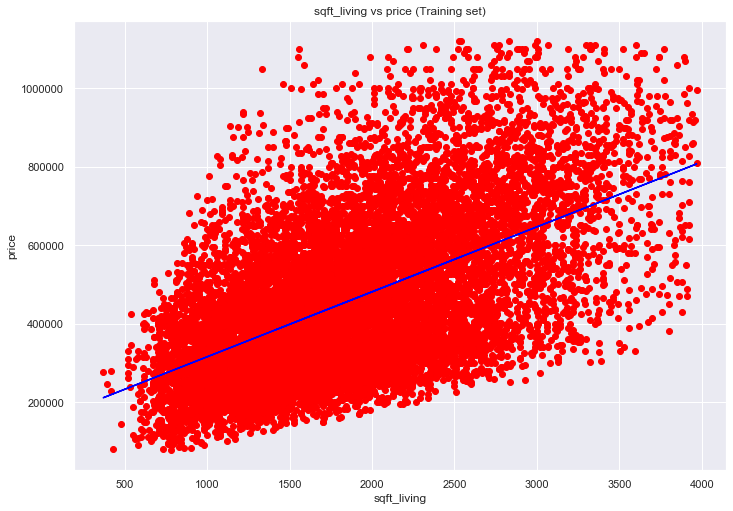

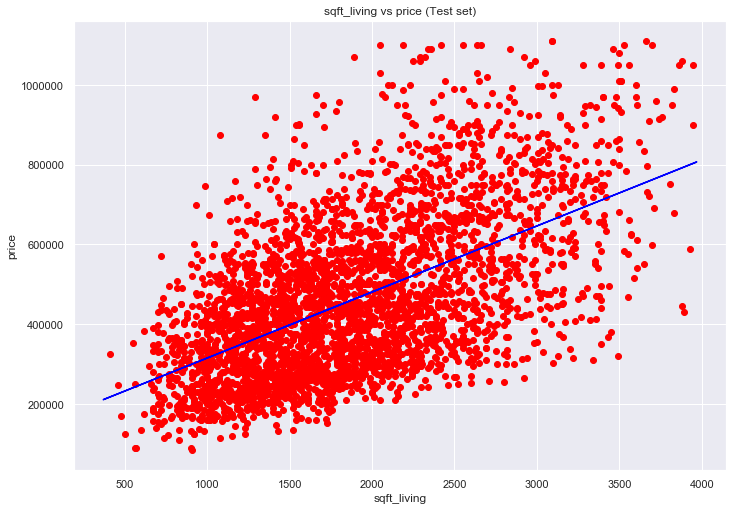

In [22]:
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, y_train)
yPrediction = linearRegressor.predict(X_test)
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, linearRegressor.predict(X_train), color = 'blue')
plt.title('sqft_living vs price (Training set)')
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.show()
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, linearRegressor.predict(X_train), color = 'blue')
plt.title('sqft_living vs price (Test set)')
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.show()

In [24]:
#Assign feature columns as list
feature_col = ['lat']

#Assign X as a subset of the data set containing only feature columns
X = df[feature_col]

#Assign to Y the target varieable
y = df['price']

#splitting X and y into training and testing data sets 
from sklearn.model_selection import train_test_split

#Assign variables to capture train test split output
X_train, X_test, y_train, y_test = train_test_split(X,y)

#import SK learn linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

#fit model to training data
linreg.fit(X_train, y_train)

#print y intercept
print(linreg.intercept_)

#print beta coefficient
print(linreg.coef_)

#predict y values using the test data from X
y_pred = linreg.predict(X_test)

#Calculate error using RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

-31167061.753549524
[664932.10275489]
175498.4805431249


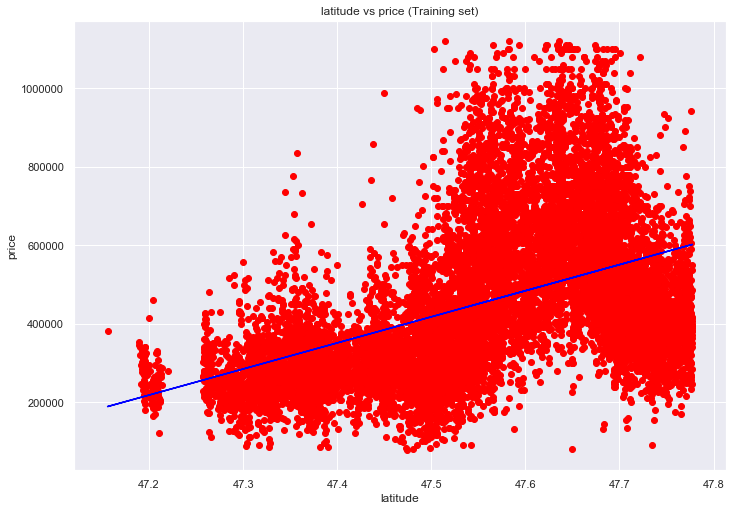

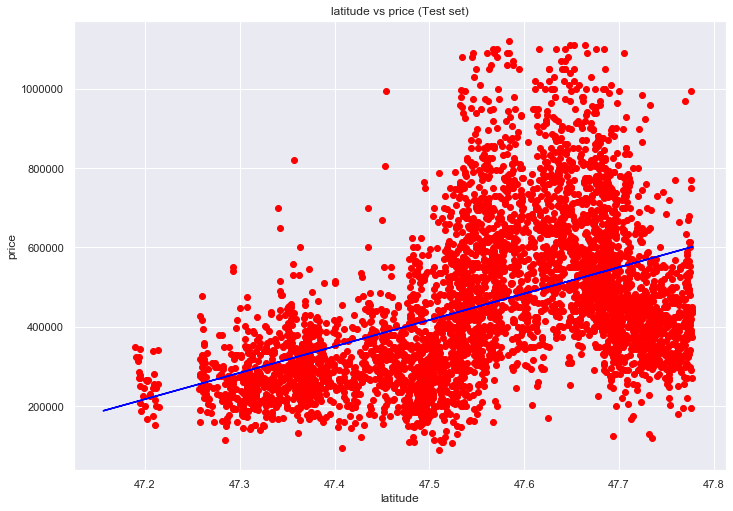

In [29]:
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, y_train)
yPrediction = linearRegressor.predict(X_test)
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, linearRegressor.predict(X_train), color = 'blue')
plt.title('latitude vs price (Training set)')
plt.xlabel('latitude')
plt.ylabel('price')
plt.show()
plt.scatter(X_test, y_test, color = 'red')
plt.plot(X_train, linearRegressor.predict(X_train), color = 'blue')
plt.title('latitude vs price (Test set)')
plt.xlabel('latitude')
plt.ylabel('price')
plt.show()

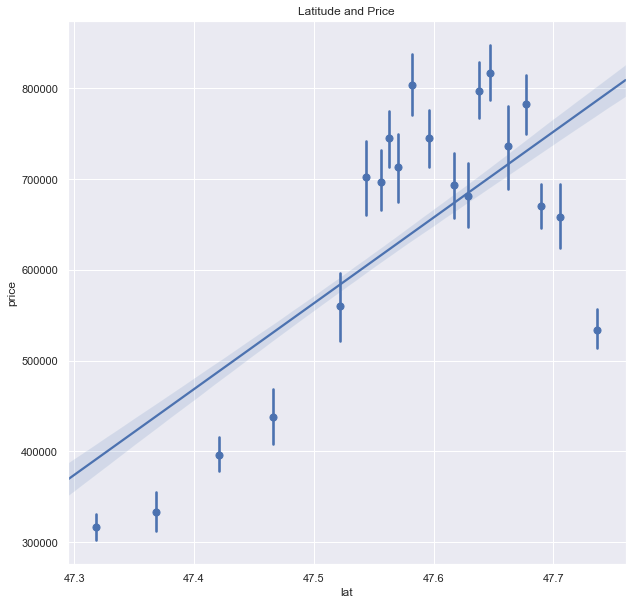

In [30]:
x = data_df['lat']
y = data_df['price']

plt.figure(figsize = (10,10))
sns.regplot(x , y, x_bins = 20, label='').set_title("Latitude and Price")

plt.show()



In [27]:
x = df['sqft_living']
y = df['price']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     8078.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:20:42   Log-Likelihood:            -2.3199e+05
No. Observations:               17288   AIC:                         4.640e+05
Df Residuals:                   17286   BIC:                         4.640e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.485e+05   3664.061     40.539      0.000    1.41e+05    1.56e+05
sqft_living   166.3940      1.851     89.876      0.000     162.765     170.023
==============================================================================
Omnibus:                      856.091   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              986.940
Skew:                           0.579   Prob(JB):                    4.88e-215
Kurtosis:                       3.177   Cond. No.                     5.86e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
x = df['lat']
y = df['price']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4741.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        15:20:43   Log-Likelihood:            -2.3321e+05
No. Observations:               17288   AIC:                         4.664e+05
Df Residuals:                   17286   BIC:                         4.664e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.103e+07   4.57e+05    -67.853      0.000   -3.19e+07   -3.01e+07
lat          6.62e+05   9615.042     68.856      0.000    6.43e+05    6.81e+05
==============================================================================
Omnibus:                     1834.605   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2522.332
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       3.755   Cond. No.                     1.64e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""